# Ensemble Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/riccardoberta/machine-learning/blob/master/02-supervised-learning/03-ensemble-learning.ipynb)


Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the **wisdom of the crowd**. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an **ensemble** and the technique **Ensemble Learning**.

We can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, we obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful ML algorithms available today.

1. [Voting Classifiers](#Voting-Classifiers)
2. [Bagging and Pasting](#Bagging-and-Pasting)
3. [Random Forests](#Random-Forests)
4. [Boosting](#Boosting)
5. [Stacking](#Stacking)
6. [Exercise](#Exercise) 

## Voting Classifiers
A simple way to create an ensamble is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting classifier**:

<img src="images/voting.png" width="400">

This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy). However, this is only true if all classifiers are **perfectly independent**, making **uncorrelated errors**. One way to get diverse classifiers is to train them using very different algorithms. How is this possible? This is due to the [**law of large numbers**](https://www.youtube.com/watch?v=VpuN8vCQ--M). Intuitivelly, suppose we try our best to train a machine and a model with 51% accuracy is all we have to show for it. It is only slightly better than random. But if we could duplicate it into 1000 models, then aggregate their individual answers into a vote, the answer with the majority of votes would be correct 73% of the time. With 10000 of these models, the voted answer would be correct 97% of the time. This is because **the probability of getting a majority of good answers increases with the number of models**.

In [5]:
import numpy as np

def model(correct_probability):
    return np.random.rand() < correct_probability

def ensemble(correct_probability, size):
    true_size = 0
    false_size = 0
    for i in range(size): 
        if model(0.51) : true_size = true_size+1
        else: false_size = false_size+1
    if true_size > false_size: return 1
    else: return 0

samples = 10000
sum = 0
for i in range(samples): 
    if model(0.51) : sum = sum+1
print (sum/samples)

sum = 0
for i in range(samples): 
    if ensemble(0.51, 1000) : sum = sum+1
print (sum/samples)

sum = 0
for i in range(samples): 
    if ensemble(0.51, 10000) : sum = sum+1
print (sum/samples)

0.5088
0.7298
0.9781


The following code trains a voting classifier composed of three diverse classifiers on the moons dataset and check each classifier’s accuracy on the test set:

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                          ('rf', rnd_clf), 
                                          ('svc', svm_clf)],
                              voting='hard')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities, then we can predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because **it gives more weight to highly confident votes**:  

<img src="images/soft-voting.png" width="600">

All you need to do n SciKitLearn is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities:

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting
Another way to get a diverse set of classifiers is to use the **same training algorithm** for every predictor and train them on **different random subsets** of the training set. In order to unserstand how we can generate the subset, we need the statistical notion of **bootstrapping**. It refers to a resample method that consists of repeatedly drawn, with replacement, samples from data to form other smaller datasets, called bootstrapping samples.  For example, let’s say we have thie training set: [2, 4, 32, 8, 16]. If we want each bootstrap subset containing $n$ observations, the following are valid samples:
n=3: [32, 4, 4], [8, 16, 2], [2, 2, 2]
n=4: [2, 32, 4, 16], [2, 4, 2, 8], [8, 32, 4, 2]…
Since we drawn data with replacement, the observations can appear more than one time in a single sample.

When sampling is performed with replacement, this method is called **bagging**  (short for **bootstrap aggregating**), otherwise it is called **pasting**. If we are using bagging, there’s a chance that a sample would never be selected, while anothers may be selected multiple time. The samples which fail to be a part of that particular subset are known as **out-og-bag** points

<img src="images/bagging.png" width="600">

When we sample with replacement, the two-sample values are independent. Practically, this means that what we get on the first one doesn’t affect what we get on the second. Mathematically, this means that the covariance between the two is zero. In sampling without replacement, the two-sample values aren’t independent. Practically, this means that what we got on for the first one affects what we can get for the second one. Mathematically, this means that the covariance between the two isn’t zero. That complicates the computations.

Scikit-Learn offers a simple API for both bagging and pasting with the **BaggingClassifier** class (or **BaggingRegressor** for regression). The following code trains a single Decision Tree and an ensemble of 500 Decision Tree classifiers, both trained on the moons dataset:

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.856
0.904


We can compares the decision boundary of the single tree with the decision boundary of the ensemble. The ensemble generalize much better than the single tree: –the decision boundary is less irregular:

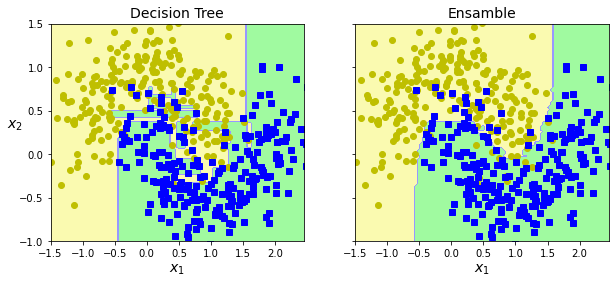

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=1, cmap=custom_cmap)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.title("Decision Tree", fontsize=14)
plot_decision_boundary(tree_clf, X, y, [-1.5, 2.45, -1, 1.5])

plt.sca(axes[1])
plt.title("Ensamble", fontsize=14)
plot_decision_boundary(bag_clf, X, y, [-1.5, 2.45, -1, 1.5])
plt.ylabel("")

plt.show()

With bagging, some instances may be sampled several times, while others may not be sampled at all. By default the BaggingClassifier samples $m$ training instances with replacement, where $m$ is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. Let's go over how the bootstrap works in order to undestand this value. We have an original sample $x_1, x_2, x_3,...,x_m$. We draw items with replacement from this original set until we have another set of size $m$. The probability of choosing any one item on the first draw is $1/m$. Therefore, the probability of not choosing that item is $1−1/m$. That's just for the first draw; there are a total of $m$ draws, all of which are independent, so the probability of never choosing this item on any of the draws is $(1−1/m)^m$. Now, let's think about what happens when $m$ gets larger and larger. We can take the limit as $m$ goes towards infinity:

In [10]:
import mpmath as mp
f = lambda m: (1.0 - 1.0/m)**m
mp.limit(f, mp.inf)

mpf('0.36787944117144233')

That's the probability of an item not being chosen. Subtract it from one to find the probability of the item being chosen, which gives you 0.632. The remaining 37% of the training instances that are not sampled are called **out-of-bag (oob)** instances. Note that they are not the same for all predictors. Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. We can evaluate the ensemble itself by averaging out the oob evaluations of each predictor. In Scikit-Learn, we can set **oob_score=True** when creating a BaggingClassifier to
request an automatic oob evaluation after training.

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            bootstrap=True,
                            oob_score=True)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9013333333333333
0.896


The BaggingClassifier class supports sampling the features as well. Sampling is
controlled by two hyperparameters: **max_features** and **bootstrap_features**. They
work the same way as max_samples and bootstrap, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the input
features. This technique is particularly useful when you are dealing with high-dimensional inputs(such as images). Sampling both training instances and features is called the **Random Patches method**. Keeping all training instances, but sampling features is called the **Random Subspaces method**. Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests
A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method, typically with max_samples set to the size of the training set. 

<img src="images/random-forest.png" width="500">

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, we can use the **RandomForestClassifier** class, which is more convenient and optimized for Decision Trees (similarly, there is a **RandomForestRegressor** class for regression tasks). The RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

0.912


The Random Forest algorithm introduces **extra randomness** when growing trees. Instead
of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. 

The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier, we can compare the accuracy.

In [11]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
                            n_estimators=500, max_samples=1.0, bootstrap=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.92


It is possible to make trees even more random by using **random thresholds** for each feature rather than searching for the best possible thresholds. A forest of such extremely random trees is called an **Extremely Randomized Trees ensemble** (or **Extra-Trees** for short). Once again, this technique trades more bias for a lower variance. It also makes it much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree. We can create an Extra-Trees classifier using Scikit-Learn’s **ExtraTreesClassifier** class.

In [12]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
extra_clf.fit(X_train, y_train)
y_pred_rf = extra_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_rf))

0.912


A great quality of Random Forests is that they make it easy to **measure the relative importance of each feature** by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). Scikit-Learn computes this score automatically for each feature after training, then it
scales the results. Weu can access the result using the **feature_importances_** variable. We can try this measure on the iris datase, as an example:

In [13]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09303345268113539
sepal width (cm) 0.0219349605340284
petal length (cm) 0.43842277537486307
petal width (cm) 0.44660881140997305


It seems that the most important features are the petal length and width (42%), while sepal length and width are rather unimportant in comparison.

We can try also to find the most important pixels on the MNIST dataset:

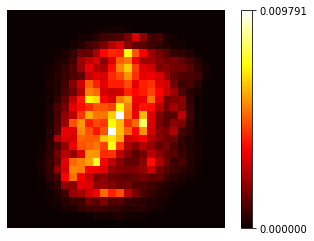

In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.hot, interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])

plt.show()

Random Forests are very handy to get **a quick understanding of what features actually
matter**, in particular if you need to perform feature selection.

## Boosting

In sequential methods the different combined weak models are no longer fitted independently from each others. The idea is to fit models iteratively such that the training of model at a given step depends on the models fitted at the previous steps. **Boosting** is the most famous of these approaches and it produces an ensemble model that is in general less biased than the weak learners that compose it. The general idea is to **train predictors sequentially, each trying to correct its predecessor**.

### AdaBoost

One way for a new predictor to correct its predecessor is **to pay a bit more attention to the training instances that the predecessor underfitted**. This results in new predictors focusing more and more on the hard cases. This is the technique used by **AdaBoost** (Adaptive Boosting). For example, when training an AdaBoost classifier, the algorithm first trains a base classifier and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on. Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set. There is one important drawback to this sequential learning technique: it cannot be parallelized, since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

<img src="images/boosting.png" width="700">

Let’s take a closer look at the algorithm. Each instance weight $w^{(i)}$ is initially set to 1/m. A first predictor is trained, and its weighted error rate $r_1$ is computed on the training set. The following formula shows the weighted error rate computed for the $j^{th}$ predictor:

$\begin{align}
r_j=\frac{\sum\limits_{i=1,\hat{y}^{(i)}\neq{y^{(i)}}}^{m}w^{(i)}}{\sum\limits_{i=1}^{m}w^{(i)}} 
\end{align}$


The predictor’s weight $\alpha_j$ is then computed using the following equation, where $\eta$ is the learning rate hyperparameter. The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its
weight will be negative

$\begin{align}
\alpha_j=\eta\log\frac{1-r_j}{r_j} 
\end{align}$

Next, the AdaBoost algorithm updates the instance weights which boosts the weights of the misclassified instances.

$w^{(i)} = 
\begin{cases}
    w^{(i)} & \text{if} & \hat{y}^{(i)}=y^{(i)} \\
    w^{(i)}\exp(\alpha) & \text{if} & \hat{y}^{(i)}\neq y^{(i)}
\end{cases}$

Then all the instance weights are normalized (i.e., divided by $\sum\limits_{i=1}^{m}w^{(i)}$)

To make predictions, AdaBoost simply computes the predictions of all the $N$ predictors and weighs them using the predictor weights $/alpha_j$. The predicted class is the one that receives the majority of weighted votes:

$\begin{align}
\hat{y}(x)=\underset{k}{argmax}=\Sigma_{j=1, \hat{y}_i(x)=k}^{N}\alpha_j
\end{align}$

Scikit-Learn uses a multiclass version of AdaBoost called **SAMME** (which stands for
"Stagewise Additive Modeling using a Multiclass Exponential loss function"). When there
are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate
class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a
variant of SAMME called SAMME.R, which relies on class probabilities rather than predictions and generally performs better.

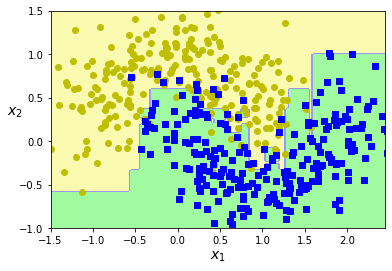

In [15]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), 
                             n_estimators=200,
                             algorithm="SAMME.R", 
                             learning_rate=0.5, 
                             random_state=42)

ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y, [-1.5, 2.45, -1, 1.5])

If the AdaBoost ensemble is overfitting the training set, we can try reducing the number of estimators or more strongly regularizing the base estimator.

### Gradient Boosting

Like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration, it tries to fit the new predictor to the **residual errors** made by the previous predictor. Let’s go through a simple regression example, using Decision Trees as the base predictors. First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set); next, we’ll train a second DecisionTreeRegressor on the residual errors made by the first predictor; then we train a third regressor on the residual errors made by the second predictor:

<img src="images/gradient-boosting.png" width="700">

In [16]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [17]:
X_new = np.array([[0.8]])
y_pred = tree_reg1.predict(X_new) + tree_reg2.predict(X_new) + tree_reg3.predict(X_new)
print(y_pred)

[0.75026781]


We can plot the predictions of these three trees and the
ensemble’s predictions:

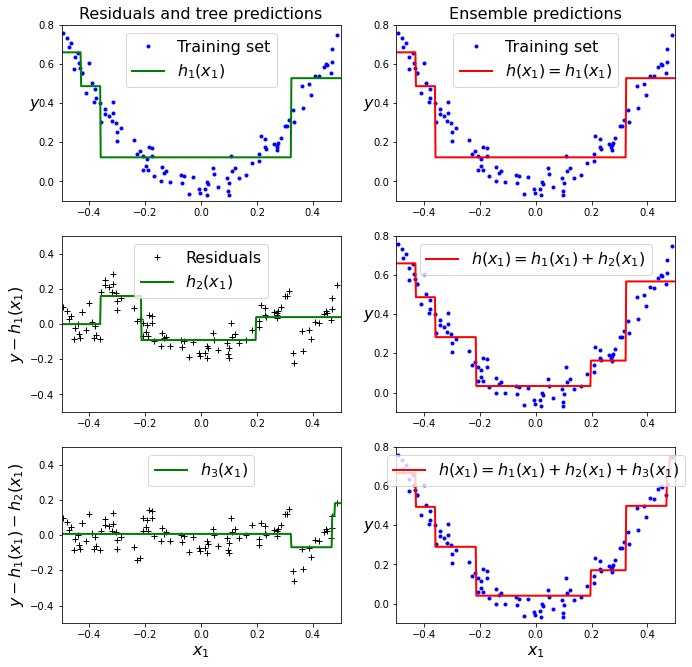

In [20]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = 0
    for regressor in regressors:
        y_pred = y_pred + regressor.predict(x1.reshape(-1, 1))
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two
trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

A simpler way to train Gradient Boosted Regression Trees ensembles is to use Scikit-Learn’s **GradientBoostingRegressor** class.

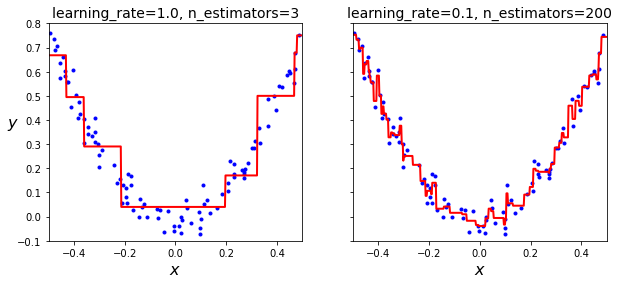

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt_1 = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt_1.fit(X, y)

gbrt_2 = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_2.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_1], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_1.learning_rate, gbrt_1.n_estimators), fontsize=14)
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_2], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_2.learning_rate, gbrt_2.n_estimators), fontsize=14)
plt.xlabel("$x$", fontsize=16)

plt.show()

The **learning_rate hyperparameter** scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called **shrinkage**. The figure shows two ensembles, the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

In order to find the optimal number of trees, we can use **early stopping**. A simple way to implement this is to use the staged_predict() method: it returns an
iterator over the predictions made by the ensemble at each stage of training (with one
tree, two trees, etc.). The following code trains am ensemble with 120 trees, then
measures the validation error at each stage of training to find the optimal number of
trees, and finally trains another ensemble using the optimal number of trees:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)

print(bst_n_estimators)
print(min_error)

56
0.002712853325235463


We can plot the validation errors and the best model’s predictions:

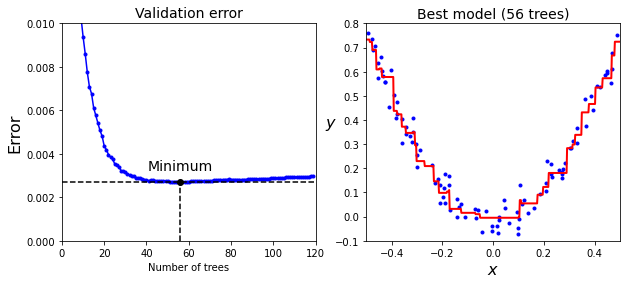

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x$", fontsize=16)

plt.show()

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting **warm_start=True**, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training.

The GradientBoostingRegressor class also supports a **subsample** hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. This technique trades a higher bias for a lower variance. It also speeds up training considerably. This is calle **Stochastic Gradient Boosting**.

## Stacking
Stacking, short for stacked generalization, is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

<img src="images/stacking.png" width="800">

To train the meta-learner (or **blender**), a common approach is to use a hold-out set. Let’s see how it
works. First, the training set is split into two subsets. The first subset is used to train the predictors in the first layer. Next, the first layer’s predictors are used to make predictions on the second (held-out) set. This ensures that the predictions are “clean,” since the predictors never saw these instances during training. For each instance in the hold-out set, there are N predicted values. We can create a new training set using these predicted values as input features, and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value, given the first layer’s predictions.

<img src="images/hold-out-set.png" width="900">

It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression), to get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially. Scikit-Learn has the **StackingClassifier class**, we ca try it on the Iris dataset:

In [17]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

X, y = load_iris(return_X_y=True)

estimator_1 = RandomForestClassifier(n_estimators=10, random_state=42)
estimator_2 = make_pipeline(StandardScaler(), LinearSVC(random_state=42))

estimators = [('rf', estimator_1),
              ('svr', estimator_2)]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print(estimator_1.fit(X_train, y_train).score(X_test, y_test))
print(estimator_2.fit(X_train, y_train).score(X_test, y_test))

print(clf.fit(X_train, y_train).score(X_test, y_test))

0.8947368421052632
0.868421052631579
0.9473684210526315


## Exercise

**1 - Load the MNIST data and split it into a training set, a validation set, and a test set. Then train various classifiers. Next, try to combine them into an ensemble that outperforms each individua classifier on the validation set, using soft or hard voting. Once you have found
one, try it on the test set. How much better does it perform compared to the
individual classifiers?**

In [23]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

print([estimator.score(X_val, y_val) for estimator in estimators])

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(random_state=42)


/Users/riccardo.berta/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training the MLPClassifier(random_state=42)
[0.9692, 0.9715, 0.8695, 0.9669]


In [25]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)
print(voting_clf.score(X_val, y_val))

/Users/riccardo.berta/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9716


The linear SVM is far outperformed by the other classifiers. Let's remove it to see if performance improves.

In [26]:
del voting_clf.estimators_[2]
print(voting_clf.score(X_val, y_val))

0.9745


Finally, we can try it on the test set.

In [27]:
print([estimator.score(X_test, y_test) for estimator in voting_clf.estimators_])
print(voting_clf.score(X_test, y_test))

[0.9645, 0.9691, 0.9647]
0.9707


The voting classifier only very slightly reduced the error rate of the best model in this case.

**2 - Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. Train a classifier on this new training set. We have just trained a blender, and together with the classifiers it forms a stacking ensemble! Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. How does it compare to the voting classifier you trained earlier?**

In [32]:
from sklearn.metrics import accuracy_score
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
rnd_forest_blender.fit(X_val_predictions, y_val)

print(rnd_forest_blender.oob_score_)

X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)
for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)
y_pred = rnd_forest_blender.predict(X_test_predictions)
                              
accuracy_score(y_test, y_pred)

0.9696


0.9688

This stacking ensemble does not perform as well as the voting classifier we trained earlier, it's not quite as good as the best individual classifier.